# Breast Cancer Classification

This exercise uses <a href="https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM#385f2cd4e86f4142b1d32bdb5803bd96"> the CBIS-DDSM (Curated Breast Imaging Subset of DDSM) dataset</a>. For the purpose of working on deep learning models regarding the csv files, we focus on two below datasets, which contain several features related to Mammography and dectection of breast cancer. 

Mass-Training-Description (csv)	
Mass-Test-Description (csv)	


The Mass-Training-Description and Mass-Test-Description include these columns:

patient_id	
breast_density	
left or right breast	
image view		
abnormality id		
abnormality type	
mass shape	
mass margins	
assessment	
pathology

There is more data in this dataset, including images, but for this homework we will not focus on them.

We are interested in this question:	
Using variables:	

breast_density	
left or right breast	
image view		
abnormality id		
abnormality type	
mass shape	
mass margins	

The goal of this exercise is to predict the **pathology type**



### Data Preparation

The output of your script should be a matrix X and a vector Y, where each row of X are one set of variables for a patient, and each row of Y is the pathology type class, for that patient.	

Use *matplotlib.imshow* to visualize the X.	
(And if there are multiple equivalent rows per patient, keep only one of them - any, up to you)


In [119]:
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pylab as plt
from torch.utils.data import Dataset, DataLoader


### Load Data

#### Method 1: Manually loading data using a load function

In [121]:
traindata = pd.read_csv('mass_case_description_train_set.csv')
testdata = pd.read_csv('mass_case_description_test_set.csv')

train_objs_num = len(traindata)
dataset = pd.concat(objs=[traindata, testdata], axis=0)

datasetx = dataset[['breast_density', 'left or right breast', 'image view', 'abnormality id', 'abnormality type', 'mass shape', 'mass margins']]
datasety = dataset[['pathology']]

dataset_preprocessed_x = pd.get_dummies(datasetx)
dataset_preprocessed_y = pd.get_dummies(datasety)

train_preprocessed_x = dataset_preprocessed_x[:train_objs_num]
train_preprocessed_y = dataset_preprocessed_y[:train_objs_num]
test_preprocessed_x = dataset_preprocessed_x[train_objs_num:]
test_preprocessed_y = dataset_preprocessed_y[train_objs_num:]


def load_data(xintermed, yintermed):
    x = xintermed.as_matrix().astype(float)
    y = yintermed.as_matrix().argmax(axis=1).astype(np.int64).reshape(-1,1)
    return x, y

xtrain, ytrain = load_data(train_preprocessed_x, train_preprocessed_y)
xtest, ytest = load_data(test_preprocessed_x, test_preprocessed_y)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


#### Method 2: Using torch DataSet and DataLoader

In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class MyDataset(Dataset):
    
    def __init__(self, size, inputdf, labeldf):
        super(MyDataset, self).__init__()
        self.size = size
        self.inputdf = inputdf
        self.labeldf = labeldf
        
    def __len__(self):
        return self.size

    def __getitem__(self, index):
        x = Variable(torch.from_numpy(self.inputdf.iloc[index,:].as_matrix().astype(float)))
        # Make an array y_ix
        y = np.array([self.labeldf.iloc[index].as_matrix().argmax()])
        # Make a long tensor
        y = Variable(torch.LongTensor(y))

                             
        return x, y

In [131]:
data_train = MyDataset(train_objs_num, train_preprocessed_x, train_preprocessed_y)
data_test = MyDataset(len(testdata), test_preprocessed_x, test_preprocessed_y)

data_train_loader = DataLoader(data_train, batch_size = 2, shuffle=True, num_workers=4)
data_test_loader = DataLoader(data_test, batch_size =2, shuffle=False, num_workers=4)

**Note**: Check to make sure that the two methods match by looking at the first x and y of the train dataset

In [135]:
x, y = next(iter(data_train))
print(x)
print(y)

tensor([3., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=torch.float64)
tensor([2])


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [136]:
xtrain[0]

array([3., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [137]:
ytrain[0]

array([2])

**Takeaways**
1. By using the DataLoader class, we already have input (x) and true label(y) as tensor. For the first method, we need to change x and y to tensors before feeding through the model.

### Modeling

#### 1. Linear Model

In [138]:
class LogReg(nn.Module):
    def __init__(self):
        super(LogReg, self).__init__()
        self.linear = nn.Linear(in_features=46, out_features=3)
        
    def forward(self, x):
        x = x.contiguous().view(-1, 46)
        # return logits
        x = self.linear(x)
        return x
    
logreg_model = LogReg().double()
    

#### 2. Multi-perceptron Model

In [26]:
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(46, 100)
        self.fc2 = nn.Linear(100, 3)


    def forward(self, x):
        x = x.contiguous().view(-1,46)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = MLPNet().double()

In [ ]:
for iter_, (x, y_true) in enumerate(data_train_loader):
    print(x.size())
    break

In [149]:
model(x)

tensor([[-0.7541, -3.6086,  4.6110],
        [-8.1075, 11.5135, -2.9870]], dtype=torch.float64,
       grad_fn=<AddmmBackward>)

In [145]:
criterion(model(x), y_true)

RuntimeError: multi-target not supported at ../aten/src/THNN/generic/ClassNLLCriterion.c:22

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
from sklearn.metrics import roc_auc_score
for epoch in range(2):
    print('Epoch {}'.format(epoch))
    
    best_weights = copy.deepcopy(model.state_dict())
    model.train()

    cur_loss = 0
    with torch.enable_grad(), \
        tqdm(total=len(data_train_loader)) as progress_bar:
        for iter_, (x, y_true) in enumerate(data_train_loader):

            if iter_ % 100:
                print(f'Phase: {phase}  Iteration {iter_+1}/{len(data_train_loader)}', end="\r")

            # zero out the parameter gradients
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                
                # Setup for forward
                x = x.to(device)
                y_true = y_true.to(device)
                batch_size = cw_idxs.size(0)
                optimizer.zero_grad()

                # Feed forward to get the logits
                log_p1 = model(x)
                loss = 
                loss_val = loss.item()
                cur_loss += loss_val * batch_size
                print('cur_loss', cur_loss)

            # Backward
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])
            optimizer.step()
            scheduler.step(step // batch_size)

            step += batch_size
            progress_bar.update(batch_size)
            progress_bar.set_postfix(epoch=epoch,
                         NLL=loss_val)

            break

        epoch_loss = cur_loss / len(train_dataset)

        print(f'Train Loss: {epoch_loss:.4f}')


    loss, f1_score, em_score = evaluate_on_dev_set(model, dev_loader, device, dev_eval_file, max_ans_len, use_squad_v2)
    print(epoch, loss, f1_score)
        

avg train loss is 0.7699072846506624
AUC train is: 0.7963586654587285
avg train loss is 0.5956114857781739
AUC train is: 0.8648584476148982
avg train loss is 0.5863919199625602
AUC train is: 0.866204699433145
avg train loss is 0.5645937318468753
AUC train is: 0.8724195879639555
avg train loss is 0.5861454052692574
AUC train is: 0.8453815955389272
avg train loss is 0.569520695646478
AUC train is: 0.8618524332810047
avg train loss is 0.5640857877484731
AUC train is: 0.8750267982489506
avg train loss is 0.5337825907450904
AUC train is: 0.8715136342574983
avg train loss is 0.5029411105663179
AUC train is: 0.8832195704442402
avg train loss is 0.5200720371371906
AUC train is: 0.8854072296488911


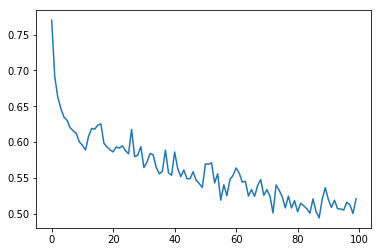

In [27]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
from sklearn.metrics import roc_auc_score

losslisttrain = []
losslisttest = []

for epoch in range(100):
    avg_loss = 0
    ix_shuffle = np.arange(xtrain.shape[0])
    np.random.shuffle(ix_shuffle)
    ypred =  np.zeros(ytrain.shape)
    for ix in ix_shuffle:
        optimizer.zero_grad()
        x = Variable(torch.from_numpy(xtrain[ix]))
        target = Variable(torch.LongTensor(ytrain[ix]))
        out = model(x)
        ypred[ix] = out.data.numpy().ravel()[2]
        loss = criterion(out, target)
        avg_loss += loss.data.numpy().ravel()[0]
        loss.backward()
        optimizer.step()
    losslisttrain.append(avg_loss/xtrain.shape[0])
    if epoch % 10 == 0:
        print('avg train loss is', avg_loss/xtrain.shape[0])
        print('AUC train is:', roc_auc_score(y_true=(ytrain==2), y_score=ypred))
plt.plot(losslisttrain); plt.show()

### Training and Testing

In [18]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
from sklearn.metrics import roc_auc_score



#training
def train(model_name):
    losslisttrain = []
    losslisttest = []
    for epoch in range(100):
        avg_loss = 0
        ix_shuffle = np.arange(xtrain.shape[0])
        np.random.shuffle(ix_shuffle)
        ypred =  np.zeros(ytrain.shape)
        for ix in ix_shuffle:
            optimizer.zero_grad()
            x = Variable(torch.from_numpy(xtrain[ix]))
            target = Variable(torch.LongTensor(ytrain[ix]))
            out = model(x)
            ypred[ix] = out.data.numpy().ravel()[2]
            loss = criterion(out, target)
            avg_loss += loss.data.numpy().ravel()[0]
            loss.backward()
            optimizer.step()
        losslisttrain.append(avg_loss/xtrain.shape[0])
        if epoch % 10 == 0:
            print('avg train loss is', avg_loss/xtrain.shape[0])
            print('AUC train is:', roc_auc_score(y_true=(ytrain==2), y_score=ypred))
    plt.plot(losslisttrain); plt.show()

In [19]:
train(MLPNet().double())

avg train loss is 0.7960835390752542
AUC train is: 0.5222200706782204
avg train loss is 0.7717780540633845
AUC train is: 0.5008460178378367
avg train loss is 0.7669401781971869
AUC train is: 0.501544501229838
avg train loss is 0.7701515551361572
AUC train is: 0.49887274462479
avg train loss is 0.7597523532944783
AUC train is: 0.5051590951528018
avg train loss is 0.7437912389606737
AUC train is: 0.5163763234877142
avg train loss is 0.7826792988148253
AUC train is: 0.5158322902186968


KeyboardInterrupt: 

avg train loss is 1.115470456995946
AUC train is: 0.4205941949806015
avg train loss is 1.1154704569959453
AUC train is: 0.4205941949806015
avg train loss is 1.115470456995947
AUC train is: 0.4205941949806015
avg train loss is 1.1154704569959466
AUC train is: 0.4205941949806015
avg train loss is 1.1154704569959455
AUC train is: 0.4205941949806015
avg train loss is 1.1154704569959448
AUC train is: 0.4205941949806015
avg train loss is 1.1154704569959455
AUC train is: 0.4205941949806015
avg train loss is 1.1154704569959455
AUC train is: 0.4205941949806015
avg train loss is 1.115470456995945
AUC train is: 0.4205941949806015
avg train loss is 1.1154704569959455
AUC train is: 0.4205941949806015


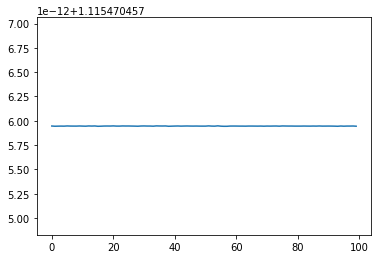

In [28]:
train(MLPNet_model)